In [75]:
%load_ext autoreload
%autoreload 2

In [76]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib import ticker

plt.style.use('https://raw.githubusercontent.com/gregdeon/plots/main/style.mplstyle')
plt.rcParams['axes.titlesize'] = 7
plt.rcParams['figure.dpi'] = 300

RESULTS_DIR = '/global/scratch/open_spiel/open_spiel/open_spiel/python/examples/notebooks/greg/results'
FIGURE_DIR = '/global/scratch/open_spiel/open_spiel/open_spiel/python/examples/notebooks/greg/figures/comparative_statics'
FIGURE_WIDTH = 7

In [80]:
# names + color scheme
METRIC_PRETTY_NAMES = {
    'total_revenue': 'Revenue ($M)',
    'total_welfare': 'Welfare',
    'auction_lengths': 'Auction Length',
    'num_lotteries': 'Number of Tiebreaks',
    'unsold_licenses': 'Unsold Licenses',
}
POLICY_PRETTY_NAMES_AND_COLORS = {
    'DROP_BY_PLAYER': ('Drop by Player', 'tab:blue'),
    'DROP_BY_LICENSE': ('Drop by License', 'tab:orange'),
}

# positioning and limits
POLICY_Y_OFFSETS = {
    'DROP_BY_PLAYER': -0.12,
    'DROP_BY_LICENSE': 0.12,
}
AXIS_LIMITS = {
    'auction_lengths': (2.9, 4.1),
    'num_lotteries': (-0.1, 1.1),
    'unsold_licenses': (-0.1, 1.1),
    'total_revenue': (42.5, 44.5),
    'total_welfare': (62.5, 87.5),
}

AXIS_LIMITS.update({f'straightforward_{k}': v for k,v in AXIS_LIMITS.items()})
METRIC_PRETTY_NAMES.update({f'straightforward_{k}': v for k,v in METRIC_PRETTY_NAMES.items()})

EPSILON = 1e-6


In [78]:
def my_fmt(x, pos):
    if x == 0:
        return '0'
    return f'{x:.2f}'

def plot_metrics_by_game(df, metrics=None, fname='plot.png', straightforward=False):
    if metrics is None:
        metrics = ['auction_lengths', 'num_lotteries', 'unsold_licenses', 'total_revenue', 'total_welfare']
        
    if straightforward:
        metrics = [f'straightforward_{m}' for m in metrics]
    
    fig, ax_list = plt.subplots(1, len(metrics), figsize=(FIGURE_WIDTH, 1.8), sharey=True)

    game_names = np.sort(df.base_game_name.unique()).tolist()

    df_plt = df[['base_game_name', 'tiebreaking_policy']].drop_duplicates().reset_index(drop=True)
    df_plt['plt_y'] = df_plt.apply(lambda x: 1 + game_names.index(x.base_game_name) + POLICY_Y_OFFSETS[x.tiebreaking_policy], axis=1)
    df_plt['plt_color'] = df_plt.tiebreaking_policy.apply(lambda x: POLICY_PRETTY_NAMES_AND_COLORS[x][1])

    df = df.merge(df_plt, on=['base_game_name', 'tiebreaking_policy'])
    agg_dict = {**{f'min_{metric}': (metric, np.min) for metric in metrics}, **{f'max_{metric}': (metric, np.max) for metric in metrics}}
    df_ranges = df.groupby(['base_game_name', 'tiebreaking_policy'], as_index=False)[metrics].agg(**agg_dict).reset_index().merge(df_plt, on=['base_game_name', 'tiebreaking_policy'])

    for i, metric in enumerate(metrics):
        plt.sca(ax_list[i])
        plt.scatter(x=df[metric], y=df.plt_y, c=df.plt_color, s=5, zorder=10, clip_on=False)
        for _, row in df_ranges.iterrows():
            plt.plot([row[f'min_{metric}'], row[f'max_{metric}']], [row.plt_y, row.plt_y], linewidth=1, color=row.plt_color, zorder=10)
        
        # xmin, xmax = AXIS_LIMITS[metric]
        # plt.xlim(xmin, xmax)
        # if min(df[metric]) < xmin - EPSILON:
        #     print(f'WARNING: minimum {metric} of {min(df[metric])} smaller than axis limit of {xmin}')
        # if max(df[metric]) > xmax + EPSILON:
        #     print(f'WARNING: maximum {metric} of {max(df[metric])} larger than axis limit of {xmax}')
        # alternative: compute x limits depending on data
        min_metric, max_metric = min(df_ranges[f'min_{metric}']), max(df_ranges[f'max_{metric}'])
        dx = max((0.05 * (max_metric - min_metric)), 0.1)
        plt.xlim(max(0, min(df[metric]) - dx), max(df[metric]) + dx)
        plt.xlabel(METRIC_PRETTY_NAMES[metric])
        plt.gca().xaxis.set_major_formatter(ticker.FuncFormatter(my_fmt))


    ax_list[0].set_ylabel('Game')
    ax_list[0].set_yticks(np.arange(1, len(game_names) + 1))
    ax_list[0].set_ylim(len(game_names) + 0.5, 0.5)

    # TODO: legend. something like this, but need to get the positioning right:
    fig.subplots_adjust(bottom=0.35)
    custom_lines = [Line2D([0], [0], color=POLICY_PRETTY_NAMES_AND_COLORS[p][1], lw=2) for p in POLICY_PRETTY_NAMES_AND_COLORS]

    fig.legend(custom_lines, [POLICY_PRETTY_NAMES_AND_COLORS[p][0] for p in POLICY_PRETTY_NAMES_AND_COLORS], loc='lower center', bbox_to_anchor=(0.5,0), ncol=2)

    # plt.tight_layout()
    path = os.path.join(FIGURE_DIR, fname)
    os.makedirs(os.path.dirname(path), exist_ok=True) # make directory if it doesn't exist
    plt.savefig(path, bbox_inches='tight')
    print(f'Saved figure to {path}')

# feb10_2p_v1

['cfr_10external_plus_linear' 'cfr_10_no_tremexternal_plus_linear_no_trem']
cfr_10_no_tremexternal_plus_linear_no_trem
Uncomputable NashConvs: 0.0%
Distribution of computed NashConvs:
count    100.0
mean       0.0
std        0.0
min        0.0
25%        0.0
50%        0.0
75%        0.0
max        0.0
Name: nash_conv, dtype: float64
Distribution of computed HeuristicConvs:
count    100.0
mean       0.0
std        0.0
min        0.0
25%        0.0
50%        0.0
75%        0.0
max        0.0
Name: heuristic_conv, dtype: float64
Saved figure to /global/scratch/open_spiel/open_spiel/open_spiel/python/examples/notebooks/greg/figures/comparative_statics/feb10_2p_v1/1.png


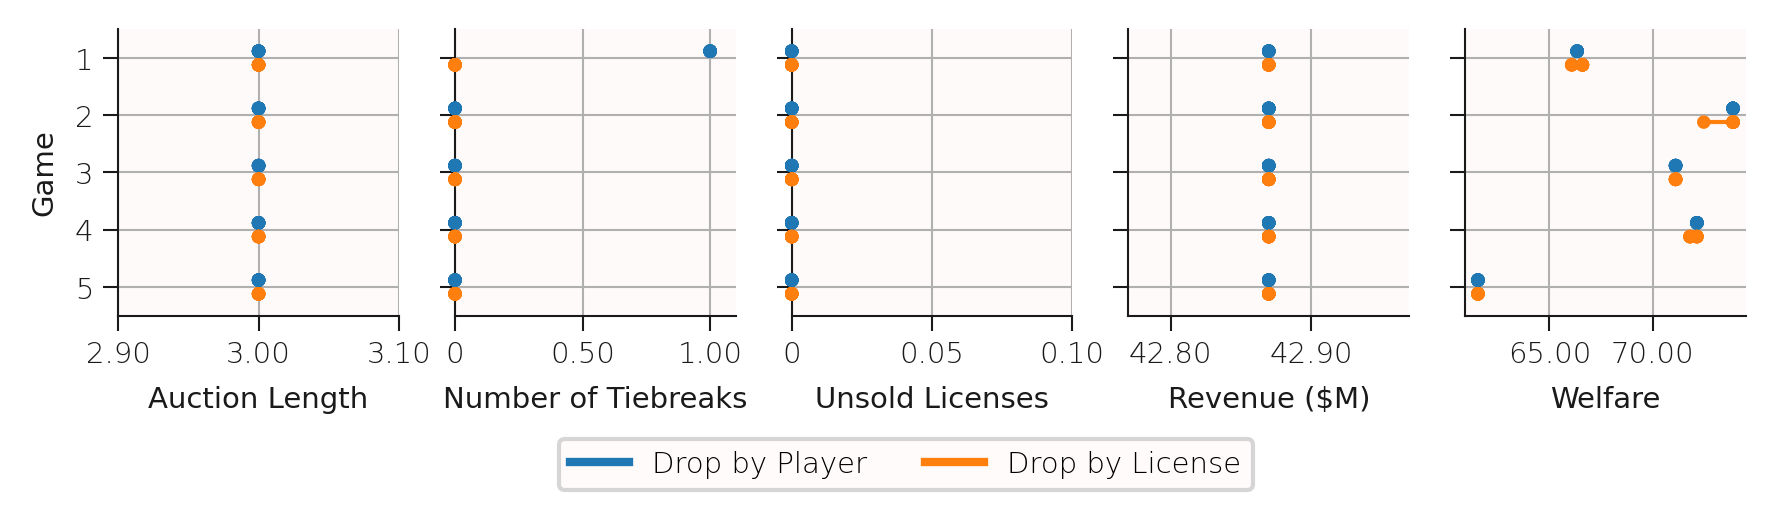

cfr_10_no_tremexternal_plus_linear_no_trem
Uncomputable NashConvs: 0.0%
Distribution of computed NashConvs:
count    100.0
mean       0.0
std        0.0
min        0.0
25%        0.0
50%        0.0
75%        0.0
max        0.0
Name: nash_conv, dtype: float64
Distribution of computed HeuristicConvs:
count    100.0
mean       0.0
std        0.0
min        0.0
25%        0.0
50%        0.0
75%        0.0
max        0.0
Name: heuristic_conv, dtype: float64
Saved figure to /global/scratch/open_spiel/open_spiel/open_spiel/python/examples/notebooks/greg/figures/comparative_statics/feb10_2p_v1/2.png


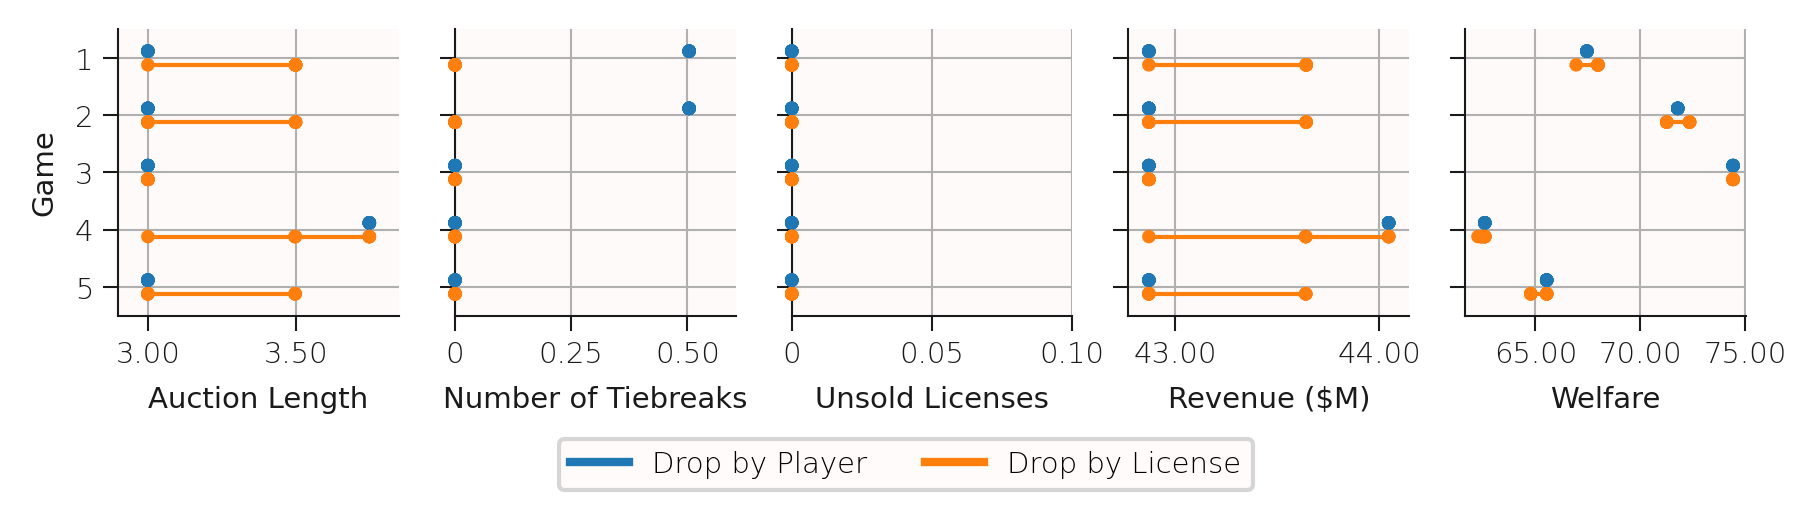

cfr_10_no_tremexternal_plus_linear_no_trem
Uncomputable NashConvs: 0.0%
Distribution of computed NashConvs:
count    100.000000
mean       0.003412
std        0.025539
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        0.231958
Name: nash_conv, dtype: float64
Distribution of computed HeuristicConvs:
count    100.0
mean       0.0
std        0.0
min        0.0
25%        0.0
50%        0.0
75%        0.0
max        0.0
Name: heuristic_conv, dtype: float64
Saved figure to /global/scratch/open_spiel/open_spiel/open_spiel/python/examples/notebooks/greg/figures/comparative_statics/feb10_2p_v1/3.png


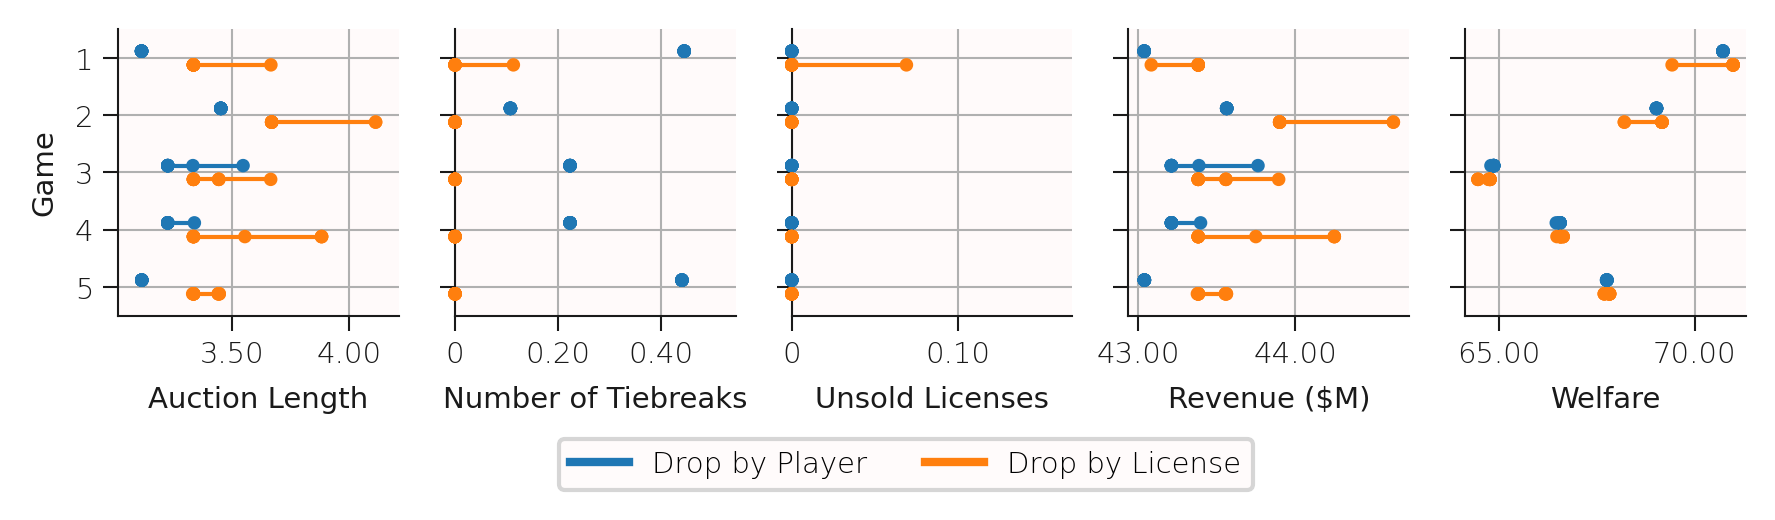

cfr_10_no_tremexternal_plus_linear_no_trem
Uncomputable NashConvs: 0.0%
Distribution of computed NashConvs:
count    100.000000
mean       0.000113
std        0.001125
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        0.011253
Name: nash_conv, dtype: float64
Distribution of computed HeuristicConvs:
count    100.000000
mean       0.000113
std        0.001125
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        0.011253
Name: heuristic_conv, dtype: float64
Saved figure to /global/scratch/open_spiel/open_spiel/open_spiel/python/examples/notebooks/greg/figures/comparative_statics/feb10_2p_v1/5.png


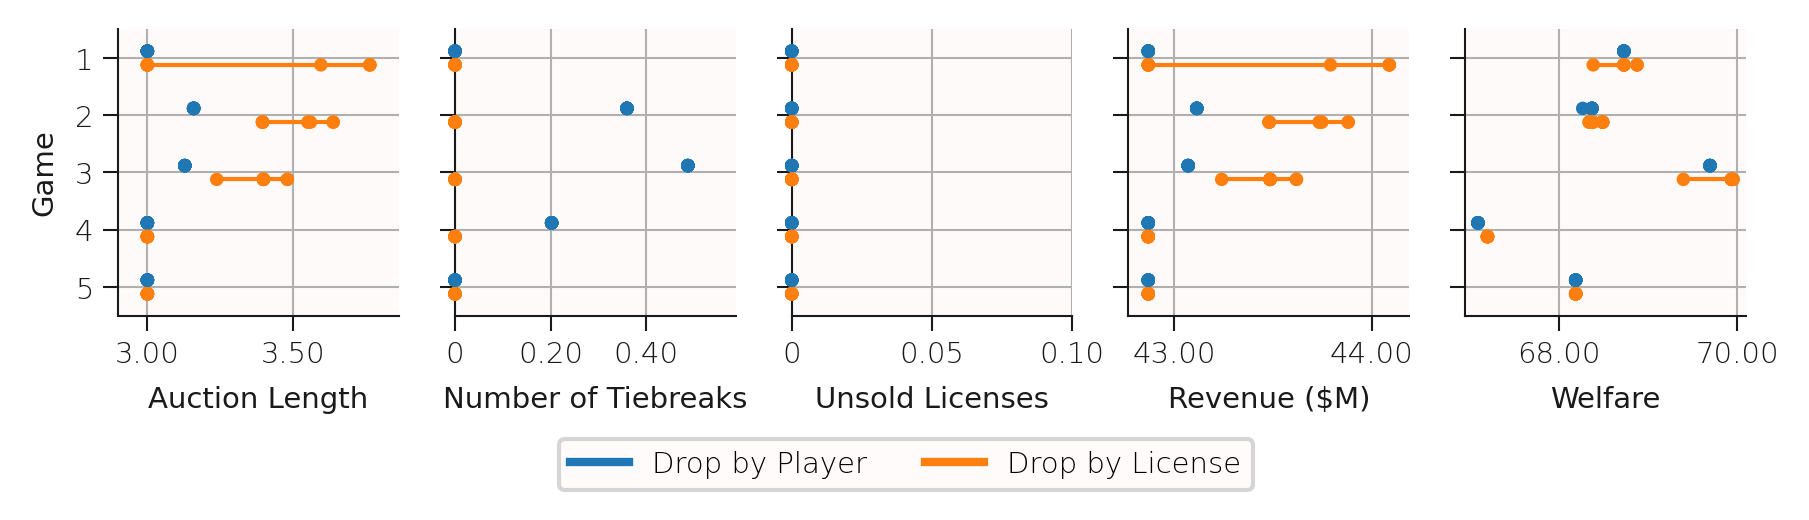

cfr_10_no_tremexternal_plus_linear_no_trem
Uncomputable NashConvs: 0.0%
Distribution of computed NashConvs:
count    100.000000
mean       0.002626
std        0.013110
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        0.088403
Name: nash_conv, dtype: float64
Distribution of computed HeuristicConvs:
count    100.000000
mean       0.000093
std        0.000626
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        0.005787
Name: heuristic_conv, dtype: float64
Saved figure to /global/scratch/open_spiel/open_spiel/open_spiel/python/examples/notebooks/greg/figures/comparative_statics/feb10_2p_v1/7.png


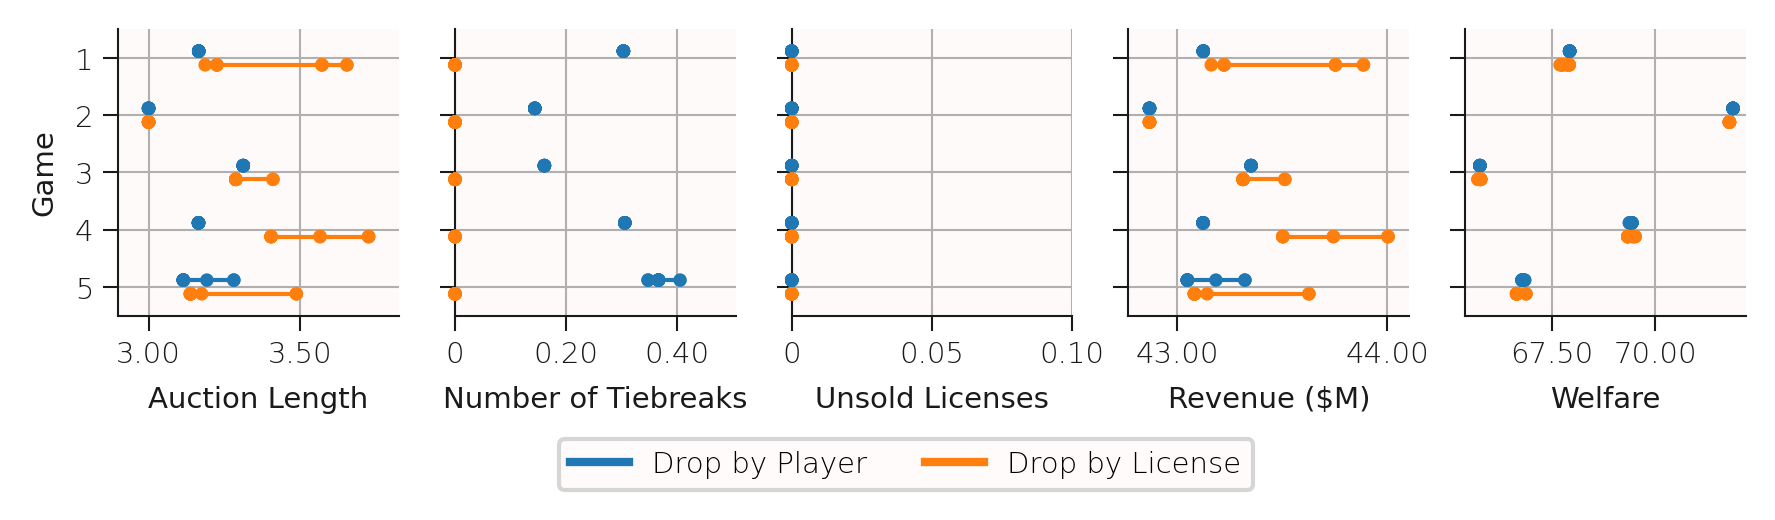

In [83]:
df = pd.read_csv(f'{RESULTS_DIR}/feb10_2p_v1.csv')

print(df.config.unique())

# cfg = 'cfr_10external_plus_linear'
cfg = 'cfr_10_no_tremexternal_plus_linear_no_trem'
for n_types in [1, 2, 3, 5, 7]:
    df_cfg = df.query(f"config == '{cfg}' and n_types == {n_types}")
    print(cfg)
    print(f'Uncomputable NashConvs: {100*df_cfg.nash_conv.isnull().mean():.1f}%')
    print(f'Distribution of computed NashConvs:')
    print(df_cfg.nash_conv.describe())
    print(f'Distribution of computed HeuristicConvs:')
    print(df_cfg.heuristic_conv.describe())
    # df_cfg_low_nashconv = df_cfg[df_cfg.nash_conv < 0.6]
    plot_metrics_by_game(df_cfg, fname=f'feb10_2p_v1/{n_types}.png'); plt.show()

# feb8_3p_5supply_v2

['cfr_10_no_tremexternal_plus_linear_no_trem' 'cfr_10external_plus_linear']
cfr_10external_plus_linear
Uncomputable NashConvs: 100.0%
Distribution of computed NashConvs:
count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN
Name: nash_conv, dtype: float64
Distribution of computed HeuristicConvs:
count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN
Name: heuristic_conv, dtype: float64
Saved figure to /global/scratch/open_spiel/open_spiel/open_spiel/python/examples/notebooks/greg/figures/comparative_statics/feb8_3p_5supply_v2/cfr_10external_plus_linear.png


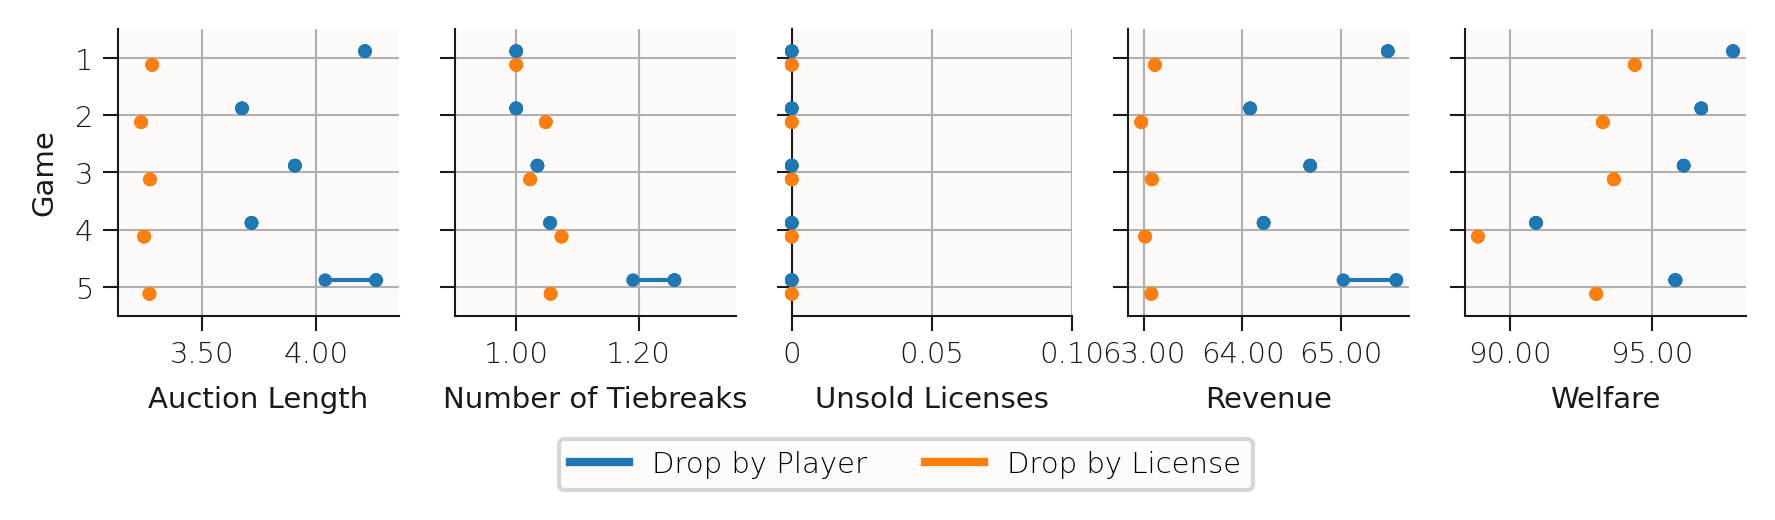

cfr_10_no_tremexternal_plus_linear_no_trem
Uncomputable NashConvs: 92.0%
Distribution of computed NashConvs:
count    4.000000
mean     0.005369
std      0.000679
min      0.004781
25%      0.004781
50%      0.005369
75%      0.005957
max      0.005957
Name: nash_conv, dtype: float64
Distribution of computed HeuristicConvs:
count    6.000000
mean     0.001594
std      0.002469
min      0.000000
25%      0.000000
50%      0.000000
75%      0.003586
max      0.004781
Name: heuristic_conv, dtype: float64
Saved figure to /global/scratch/open_spiel/open_spiel/open_spiel/python/examples/notebooks/greg/figures/comparative_statics/feb8_3p_5supply_v2/cfr_10_no_tremexternal_plus_linear_no_trem.png


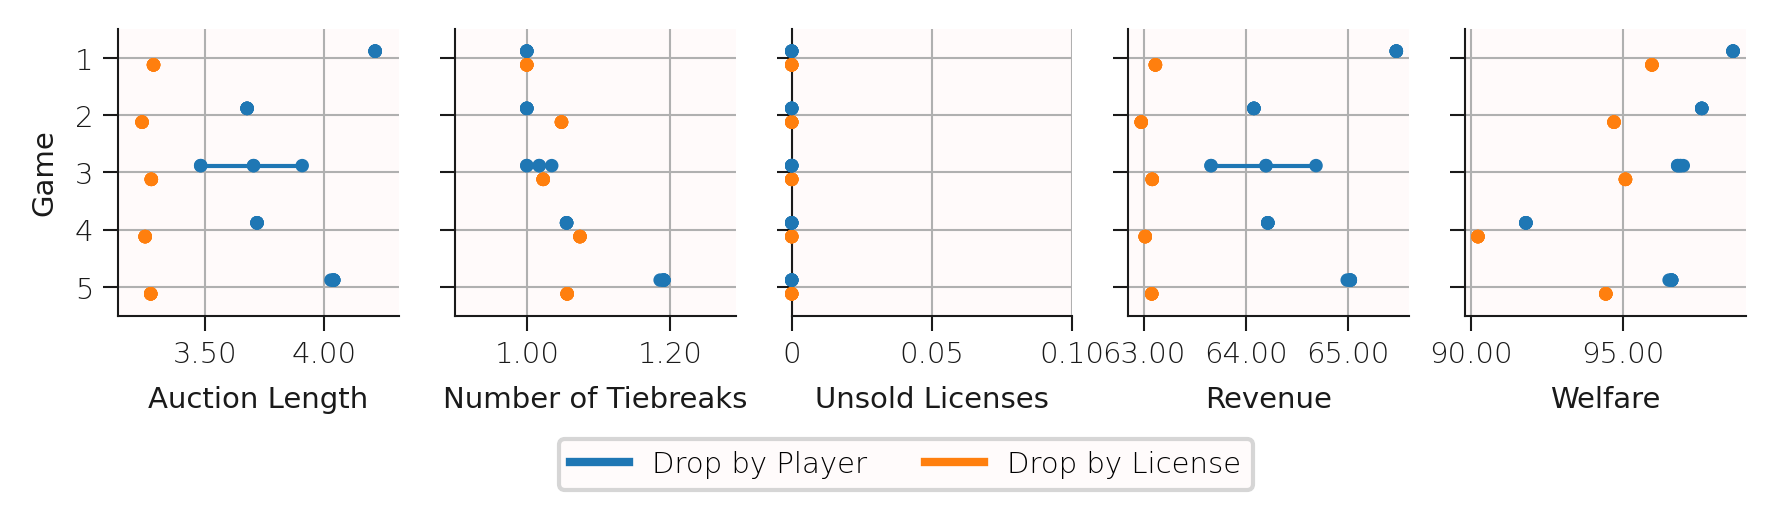

In [39]:
df = pd.read_csv(f'{RESULTS_DIR}/feb8_3p_5supply_v2.csv')

print(df.config.unique())

for cfg in ['cfr_10external_plus_linear', 'cfr_10_no_tremexternal_plus_linear_no_trem']:
    df_cfg = df.query(f"config == '{cfg}'")
    print(cfg)
    print(f'Uncomputable NashConvs: {100*df_cfg.nash_conv.isnull().mean():.1f}%')
    print(f'Distribution of computed NashConvs:')
    print(df_cfg.nash_conv.describe())
    print(f'Distribution of computed HeuristicConvs:')
    print(df_cfg.heuristic_conv.describe())
    # df_cfg_low_nashconv = df_cfg[df_cfg.nash_conv < 0.6]
    plot_metrics_by_game(df_cfg, fname=f'feb8_3p_5supply_v2/{cfg}.png'); plt.show()

# feb8_3p_5supply_v1
3 players, 5 encumbered licenses

cfr_10external_plus_linear
Uncomputable NashConvs: 98.0%
Distribution of computed NashConvs:
count    1.000000
mean     0.000478
std           NaN
min      0.000478
25%      0.000478
50%      0.000478
75%      0.000478
max      0.000478
Name: nash_conv, dtype: float64
Distribution of computed HeuristicConvs:
count    2.000000
mean     0.001930
std      0.002053
min      0.000478
25%      0.001204
50%      0.001930
75%      0.002656
max      0.003382
Name: heuristic_conv, dtype: float64
Saved figure to /global/scratch/open_spiel/open_spiel/open_spiel/python/examples/notebooks/greg/figures/comparative_statics/feb8_3p_5supply_v1/cfr_10external_plus_linear.png


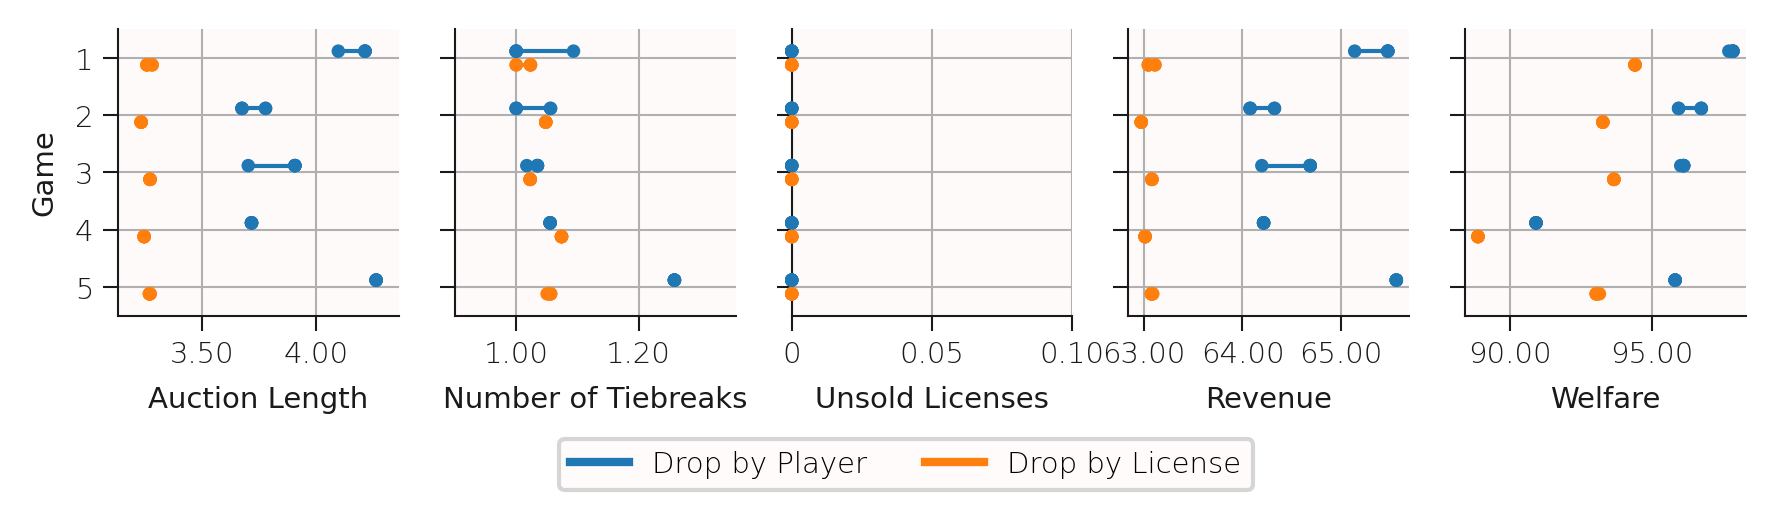

ppo_jun8_23ppo_76
Uncomputable NashConvs: 100.0%
Distribution of computed NashConvs:
count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN
Name: nash_conv, dtype: float64
Distribution of computed HeuristicConvs:
count    1.000000
mean     0.021356
std           NaN
min      0.021356
25%      0.021356
50%      0.021356
75%      0.021356
max      0.021356
Name: heuristic_conv, dtype: float64


ValueError: Axis limits cannot be NaN or Inf

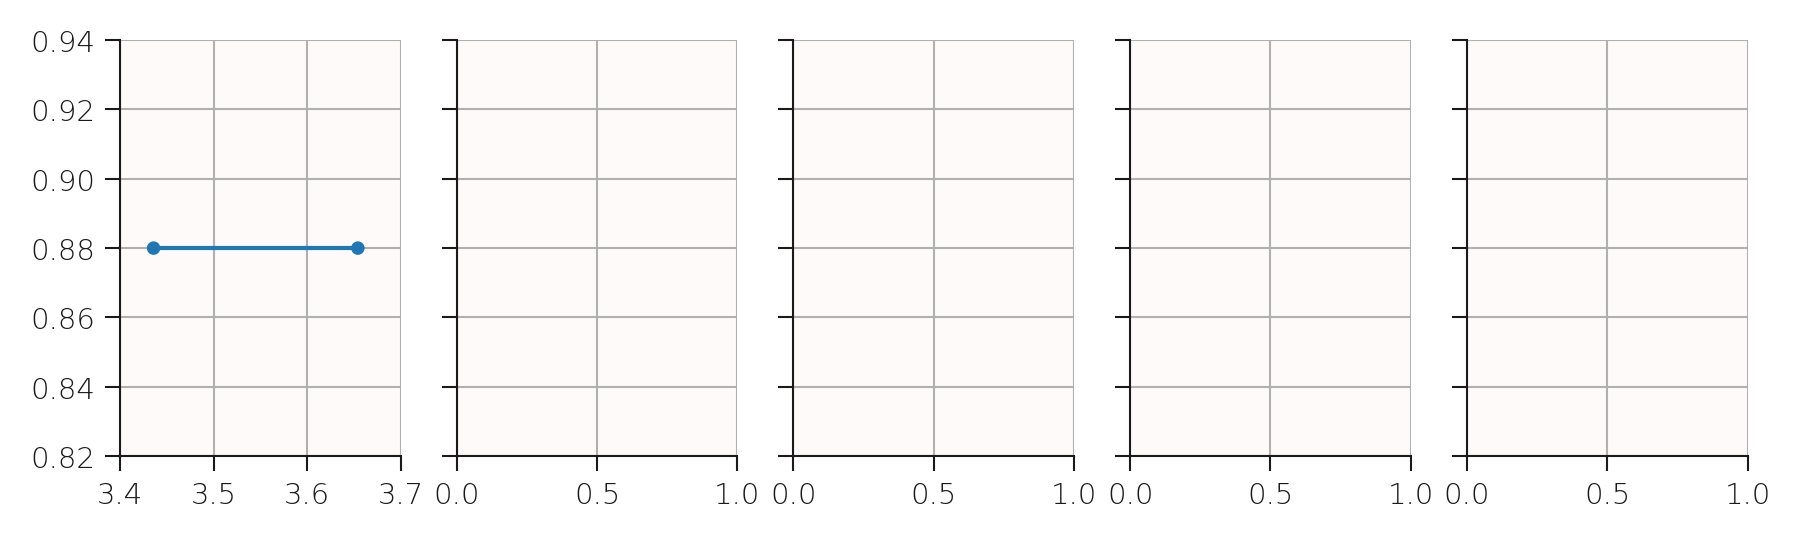

In [34]:
df = pd.read_csv(f'{RESULTS_DIR}/feb8_3p_5supply_v1.csv')

for cfg in ['cfr_10external_plus_linear', 'ppo_jun8_23ppo_76']:
    df_cfg = df.query(f"config == '{cfg}' and rho == 1")
    print(cfg)
    print(f'Uncomputable NashConvs: {100*df_cfg.nash_conv.isnull().mean():.1f}%')
    print(f'Distribution of computed NashConvs:')
    print(df_cfg.nash_conv.describe())
    print(f'Distribution of computed HeuristicConvs:')
    print(df_cfg.heuristic_conv.describe())
    # df_cfg_low_nashconv = df_cfg[df_cfg.nash_conv < 0.6]
    plot_metrics_by_game(df_cfg, fname=f'feb8_3p_5supply_v1/{cfg}.png'); plt.show()

# feb8_3p_7supply_v2
3 players, 7 encumbered licenses

cfr_10external_plus_linear
Uncomputable NashConvs: 0.0%
Distribution of computed NashConvs:
count    50.0
mean      0.0
std       0.0
min       0.0
25%       0.0
50%       0.0
75%       0.0
max       0.0
Name: nash_conv, dtype: float64
Saved figure to /global/scratch/open_spiel/open_spiel/open_spiel/python/examples/notebooks/greg/figures/comparative_statics/feb8_3p_7supply_v2/cfr_10external_plus_linear.png


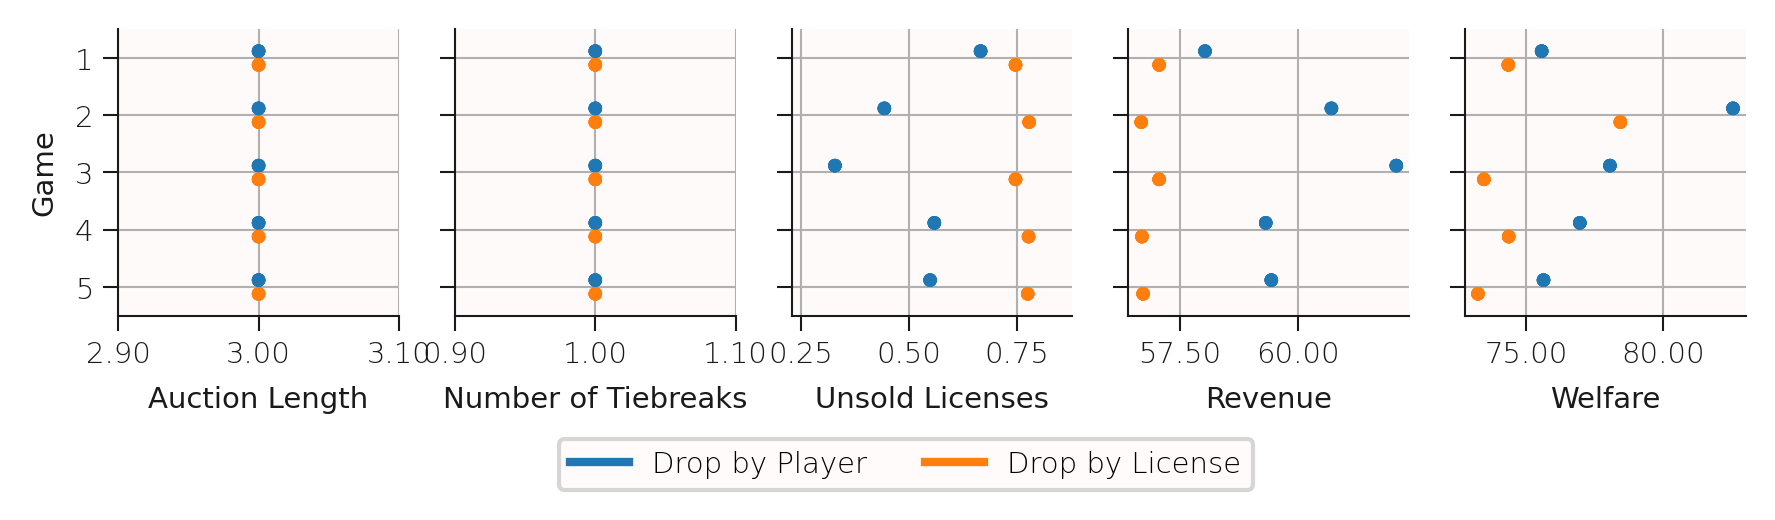

ppo_jun8_23ppo_76
Uncomputable NashConvs: 26.0%
Distribution of computed NashConvs:
count    37.000000
mean      0.065319
std       0.085062
min       0.000000
25%       0.010195
50%       0.026719
75%       0.067375
max       0.285998
Name: nash_conv, dtype: float64
Saved figure to /global/scratch/open_spiel/open_spiel/open_spiel/python/examples/notebooks/greg/figures/comparative_statics/feb8_3p_7supply_v2/ppo_jun8_23ppo_76.png


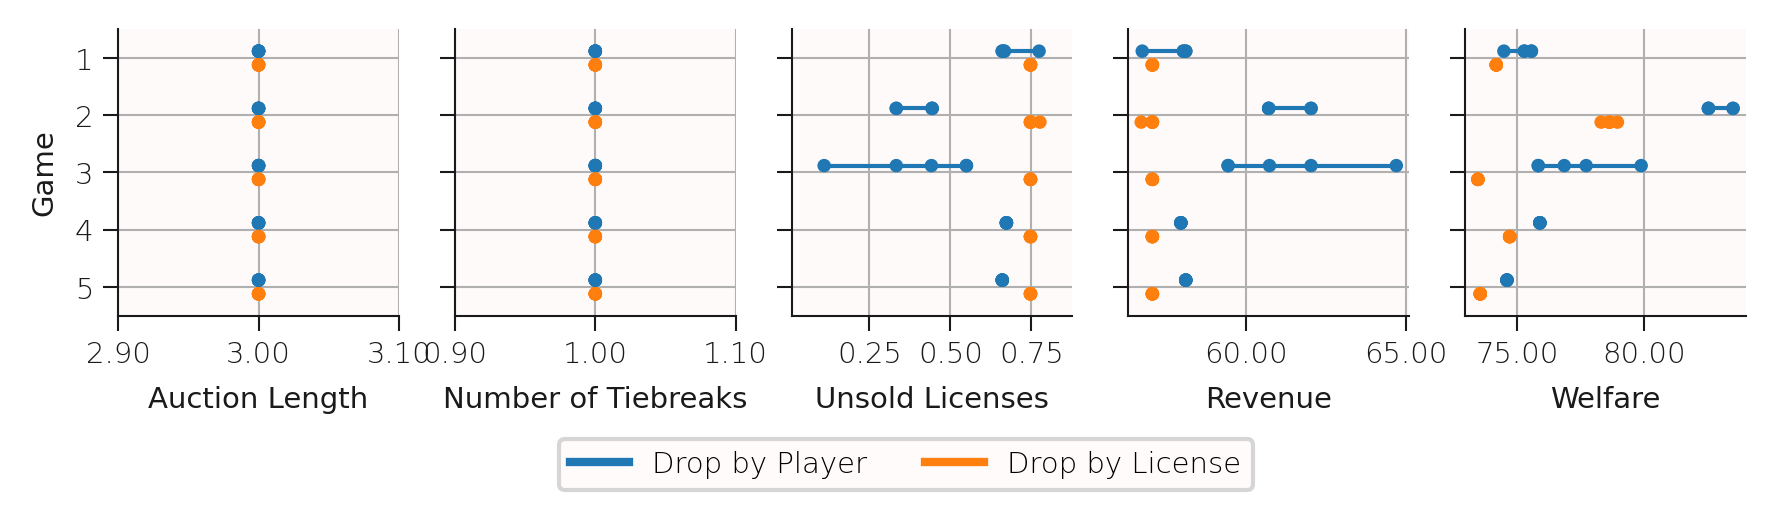

In [32]:
df = pd.read_csv(f'{RESULTS_DIR}/feb8_3p_7supply_v2.csv')

for cfg in ['cfr_10external_plus_linear', 'ppo_jun8_23ppo_76']:
    df_cfg = df.query(f"config == '{cfg}' and rho == 1")
    print(cfg)
    print(f'Uncomputable NashConvs: {100*df_cfg.nash_conv.isnull().mean():.1f}%')
    print(f'Distribution of computed NashConvs:')
    print(df_cfg.nash_conv.describe())
    # df_cfg_low_nashconv = df_cfg[df_cfg.nash_conv < 0.6]
    plot_metrics_by_game(df_cfg, fname=f'feb8_3p_7supply_v2/{cfg}.png'); plt.show()

# feb8_v1

cfr_port_10_extexternal_plus_linear
Uncomputable NashConvs: 27.3%
Distribution of computed NashConvs:
count    80.000000
mean      0.009921
std       0.061899
min       0.000000
25%       0.000000
50%       0.000000
75%       0.000000
max       0.426840
Name: nash_conv, dtype: float64
Saved figure to /global/scratch/open_spiel/open_spiel/open_spiel/python/examples/notebooks/greg/figures/comparative_statics/feb8_v1/cfr_port_10_extexternal_plus_linear.png


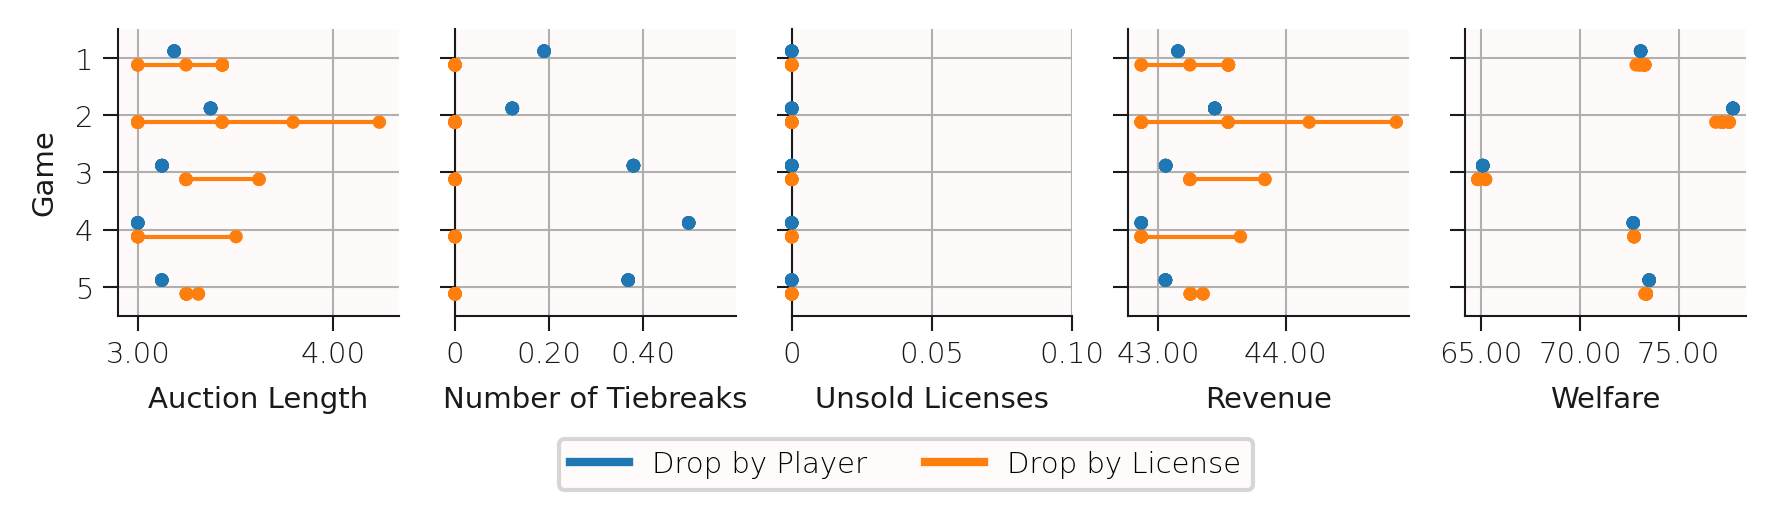

cfr_port_10_extexternal_plus_linear_no_trem
Uncomputable NashConvs: 18.2%
Distribution of computed NashConvs:
count    90.000000
mean      0.000214
std       0.000646
min       0.000000
25%       0.000000
50%       0.000000
75%       0.000000
max       0.002140
Name: nash_conv, dtype: float64
Saved figure to /global/scratch/open_spiel/open_spiel/open_spiel/python/examples/notebooks/greg/figures/comparative_statics/feb8_v1/cfr_port_10_extexternal_plus_linear_no_trem.png


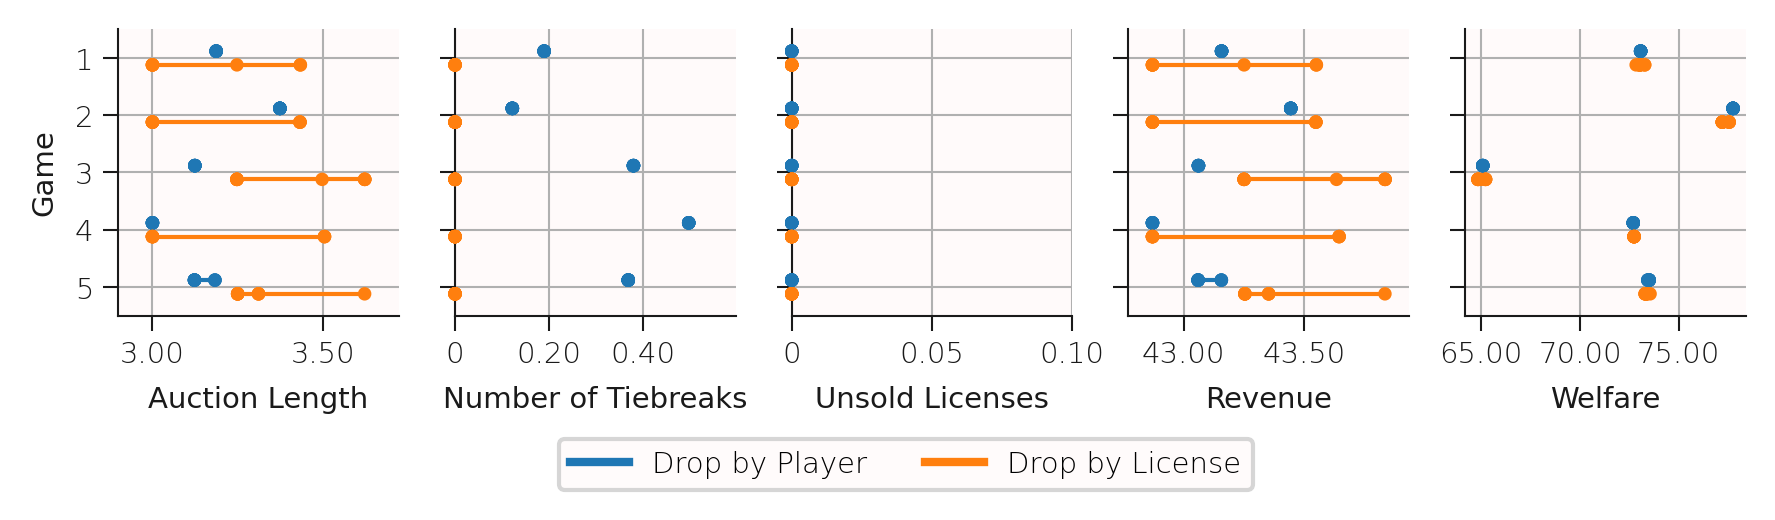

ppo_jun8_23ppo_76
Uncomputable NashConvs: 0.0%
Distribution of computed NashConvs:
count    110.000000
mean       0.299507
std        1.103819
min        0.000000
25%        0.000000
50%        0.000000
75%        0.179375
max       10.699844
Name: nash_conv, dtype: float64
Saved figure to /global/scratch/open_spiel/open_spiel/open_spiel/python/examples/notebooks/greg/figures/comparative_statics/feb8_v1/ppo_jun8_23ppo_76.png


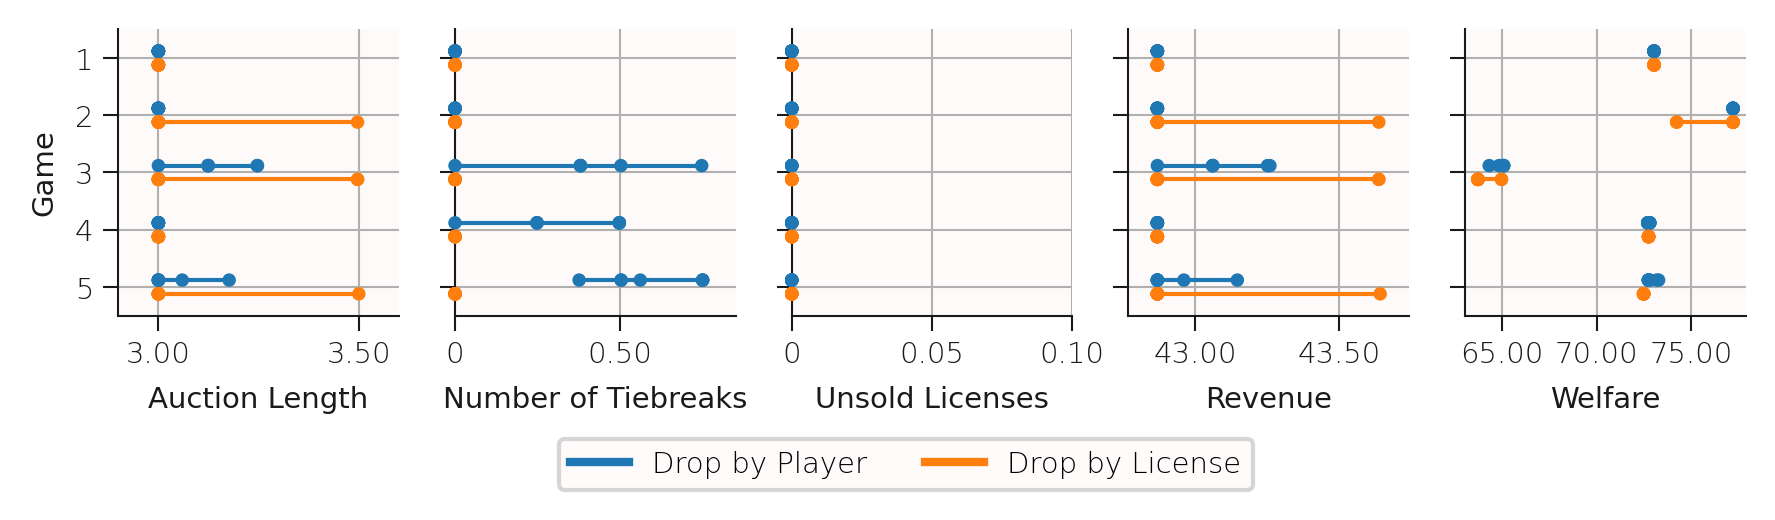

In [35]:
df = pd.read_csv(f'{RESULTS_DIR}/feb8_v1.csv')

for cfg in ['cfr_port_10_extexternal_plus_linear', 'cfr_port_10_extexternal_plus_linear_no_trem', 'ppo_jun8_23ppo_76']:
    df_cfg = df.query(f"config == '{cfg}' and rho == 0")
    print(cfg)
    print(f'Uncomputable NashConvs: {100*df_cfg.nash_conv.isnull().mean():.1f}%')
    print(f'Distribution of computed NashConvs:')
    print(df_cfg.nash_conv.describe())
    df_cfg_low_nashconv = df_cfg[df_cfg.nash_conv < 0.6]
    plot_metrics_by_game(df_cfg_low_nashconv, fname=f'feb8_v1/{cfg}.png'); plt.show()

# feb6_v2

In [14]:
df = pd.read_csv(f'{RESULTS_DIR}/feb6_v2.csv')

In [21]:
for rho in [1, 0]:
    plot_metrics_by_game(df.query(f'rho == {rho}'), fname=f'feb6_v2/rho{rho}.png'); plt.show()
    plot_metrics_by_game(df.query(f'rho == {rho} and nash_conv < 0.05'), fname=f'feb6_v2/rho{rho}_low_nashconv.png'); plt.show()

In [10]:
(df.nash_conv < 0.2).mean()

0.7727272727272727